In [1]:
import torch

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.3.0+cu121
12.1
True


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests # requests for the report website
import json
from sec_edgar_api import EdgarClient
from bs4 import BeautifulSoup # Import BeautifulSoup
import re # import re module for REGEXes
import time
import os
import html2text
from nltk.tokenize import sent_tokenize
import nltk
import matplotlib.pyplot as plt
from scipy import stats
nltk.download('punkt')


# Create a folder for save data
# os.mkdir('Data') 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yili8\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
CompanyTickers = requests.get('https://www.sec.gov/files/company_tickers.json',
                              headers={'User-Agent':"test@gmail.com"})


CompanyTicker = open('CompanyTickers.json','w+')
CompanyTicker.write(json.dumps(CompanyTickers.json()))
CompanyTicker.close()

CompanyData = pd.DataFrame.from_dict(CompanyTickers.json(), orient='index')
display(CompanyData)

,cik_str,ticker,title
0,789019,MSFT,MICROSOFT CORP
1,320193,AAPL,Apple Inc.
2,1045810,NVDA,NVIDIA CORP
3,1652044,GOOGL,Alphabet Inc.
4,1018724,AMZN,AMAZON COM INC
...,...,...,...
10247,1512228,NIOBW,NIOCORP DEVELOPMENTS LTD
10248,1900402,EVGRU,Evergreen Corp
10249,1900402,EVGRW,Evergreen Corp
10250,1447100,YMHAY,"Yamaha Motor Co., Ltd."


In [5]:
# read bloomberg excel with company
df=pd.read_excel('C:/Users/yili8/Desktop/ESG Final Project/oil & gas (us)-G.xlsx')
df = df[1:]
df['Unnamed: 1'] = df['Unnamed: 1'].str.replace(' US Equity', '', regex=False)
display(df['Unnamed: 1'])

1       APA
2      AXAS
3        AE
4       APC
5      ANDX
       ... 
201     WES
202     WLL
203     WMB
204     WKC
205    ZNOG
Name: Unnamed: 1, Length: 205, dtype: object

In [6]:
def FindCompanyCik(Ticker):
    for i in CompanyTickers.json().keys():
        if CompanyTickers.json()[i]['ticker'] ==Ticker:
            print(CompanyTickers.json()[i])
            return CompanyTickers.json()[i]['cik_str']
            break

In [7]:
def checkExistingof10k (Companycik):
    edgar = EdgarClient(user_agent="test@gmail.com")
    try:
        test = edgar.get_company_concept(cik=Companycik, taxonomy="us-gaap", tag="AccountsPayableCurrent")
        print(test)
        reportRecord = pd.DataFrame.from_dict(test['units']['USD'])
        pass
    except:
        return False
        pass
    display(reportRecord)
    type='10-K'
    if type in reportRecord['form'].values:
        return True
    else:
        return False 

In [9]:
def SearchIndexContents(text):
    #IndexContent = re.compile(r'((ITEM \d+\.\ *\s*(.*?)\n))|(Item \d+\.\ *\s*(.*?)\n)').finditer(text)
    IndexContent = re.compile(r'((ITEM\ *\d+\.\ *\s*(.*?)\n))|(Item\ *\d+\.\ *\s*(.*?)\n)', re.IGNORECASE).finditer(text)


    ItemIndex_df = pd.DataFrame([(match.group().strip(), match.start(), match.end()) for match in IndexContent])
    ItemIndex_df.columns = ['Item', 'start', 'end']
    if len(ItemIndex_df) > 16:
        ItemIndex_df = ItemIndex_df[(len(ItemIndex_df)-16):len(ItemIndex_df)]
    ItemIndex_df = ItemIndex_df.reset_index(drop=True)
    display(ItemIndex_df)
    return ItemIndex_df


In [10]:
def Extractedtext(dataframe:pd,Item:int,report:str):
    start_items = dataframe[dataframe['Item'].str.contains(f"ITEM\s+{Item}", case=False, regex=True)]
    #print(start_items['start'])
    end_items = dataframe[dataframe['Item'].str.contains(f"ITEM\s+{Item+1}", case=False, regex=True)]
    #print(end_items['start'])
    if (start_items.empty==True) or (end_items.empty==True):
        #print('All in empty')
        return ""
    else:
        start_index = start_items.iloc[0]['start']
        end_index = end_items.iloc[0]['start']
        extracted_text = report[start_index:end_index].strip()
        extracted_text = re.sub(r'\*|\_|\||\#|\-', '', extracted_text)
        extracted_text = re.sub(r'\n', ' ', extracted_text)
        return(extracted_text)

In [11]:
def ExtractESG(text):
    ReportIndex = SearchIndexContents(text)

    item1 = Extractedtext(ReportIndex,1,text)
    item3 = Extractedtext(ReportIndex,3,text)
    item7 = Extractedtext(ReportIndex,7,text)
    item10 = Extractedtext(ReportIndex,10,text)
    item11 = Extractedtext(ReportIndex,11,text)
    item12 = Extractedtext(ReportIndex,12,text)
    All = item1 + ' '+ item3 +' '+ item7 +' '+ item10 +' '+ item11 +' '+ item12
    Split = sent_tokenize(All)
    
    return Split

In [12]:
def Download10kdata(Companycik):
    edgar = EdgarClient(user_agent="test@gmail.com")
    test = edgar.get_company_concept(cik=Companycik, taxonomy="us-gaap", tag="AccountsPayableCurrent")
    reportRecord = pd.DataFrame.from_dict(test['units']['USD'])
    display(reportRecord)
    Company10K = reportRecord[reportRecord['form']=='10-K']
    display(Company10K)
    Company10K=Company10K.drop_duplicates(['fy'])
    Company10K=Company10K.set_index('fy')
    display(Company10K)
    os.mkdir(f"{CompanyName}")
    for i,row in Company10K.iterrows():  
        accn = row['accn']
        print(accn)
        accnid = accn.replace('-','')
        #print(accnid)
        #time.sleep(1)
        Report_10K = requests.get(f'https://www.sec.gov/Archives/edgar/data/{Companycik}/{accnid}/{accn}.txt',
                              headers={'User-Agent':"test@gmail.com"})
        print(Report_10K)
        raw_10k = Report_10K.text
        clear10K = html2text.html2text(raw_10k)
        print(clear10K)
        split = ExtractESG(clear10K)
        print(split)
        # Create a folder for save data
        # os.mkdir('ReportSplitSentences') 
        df = pd.DataFrame(split)
        df.to_csv(f"{CompanyName}/{CompanyName}-{i}.csv",index=False)


In [ ]:
industry =['AE', 'AM', 'AR', 'AROC', 'ARIS', 'BKR', 'BSM', 'BDCO', 'VTOL', 'CNX', 'CVI','CVX', 'CRC', 'CEI', 'CHX', 'LNG', 'CQP', 'CHK', 'CX', 'CHRD', 'CLNE', 'CRK', 'COP', 'CLB', 'CTRA', 'CRGY', 'BOOM', 'DNOW', 'DTM', 'DWSN', 'DK', 'DO', 'DRQ', 'EOG', 'EQT', 'ENLC', 'ET', 'EPD', 'ETRN', 'EPM', 'XPRO', 'FTK', 'FET', 'GEOS', 'GTE', 'GIFI', 'GPOR', 'DINO', 'HAL', 'HLX', 'HP', 'HES', 'HESM', 'HUSA', 'ICD', 'KRP', 'KMI', 'KNTK', 'KOS', 'LBRT', 'MIND', 'MPLX', 'MGY', 'TUSK', 'MRO', 'MPC', 'MTDR', 'MTRX', 'MUR', 'NCSM', 'NOV', 'NBR', 'NGS', 'NFE', 'NR', 'NEXT', 'NINE', 'NE', 'NOG', 'OKE', 'OXY', 'OII', 'OIS', 'PBF', 'PHX', 'PARR', 'PTEN', 'PR', 'PSX', 'PNRG', 'PUMP', 'PFIE', 'RES', 'RRC', 'RNGR', 'RSRV', 'REPX', 'REI', 'SM', 'SD', 'WTTR', 'SBOW', 'SND', 'SOI', 'SWN', 'SLNG', 'SUN', 'TALO', 'TRGP', 'FTI', 'TELL', 'TDW', 'RIG', 'USEG', 'SLCA', 'UNTC', 'EGY', 'VLO', 'VTNR', 'VYEY', 'VNOM', 'VTLE', 'WTI', 'WFRD', 'WMB', 'WKC','ZNOG']

for item in industry:
    CompanyName = item
    Companycik = FindCompanyCik(CompanyName)
    Download10kdata(Companycik)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import os
import pandas as pd

folder_path = "C:/Users/yili8/Desktop/ESG Code/SpiltSentencesFile(oil & gas)"
for root, dirs, files in os.walk(folder_path):
    for file in files:
        df = pd.read_csv('C:/Users/yili8/Desktop/ESG Final Project/Load Data.ipynb (split) (2).csv')
        sentences = df["split"].tolist()
        finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
        tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
        nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer)
        none_probs, e_probs, s_probs, g_probs, labels = [], [], [], [], []
        for sentence in sentences:
            inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
            outputs = finbert(**inputs)
            scores = torch.softmax(outputs.logits, dim=1).detach().numpy()[0]     
            none_probs.append(scores[0])
            e_probs.append(scores[1])
            s_probs.append(scores[2])
            g_probs.append(scores[3])
            max_score_index = scores.argmax()
            labels.append(label_mapping[max_score_index])

        df['None'] = none_probs
        df['E'] = e_probs
        df['S'] = s_probs
        df['G'] = g_probs
        df['Label'] = labels
        output_file_path = os.path.join(output_folder_path, file.replace(".csv", "_with_scores.csv"))
        df.to_csv(output_file_path, index=False)
      


In [7]:
industry =['AE', 'AM', 'AR', 'AROC', 'ARIS', 'BKR', 'BSM', 'BDCO', 'VTOL', 'CNX', 'CVI', 'CVX','CRC', 'CEI', 'CHX', 'LNG', 'CQP', 'CHK', 'CX', 'CHRD', 'CLNE', 'CRK', 'COP', 'CLB', 'CTRA', 'CRGY', 'BOOM', 'DNOW', 'DTM', 'DWSN', 'DK', 'DO', 'DRQ', 'EOG', 'EQT', 'ENLC', 'ET', 'EPD', 'ETRN', 'EPM', 'XPRO', 'FTK', 'FET', 'GEOS', 'GTE', 'GIFI', 'GPOR', 'DINO', 'HAL', 'HLX', 'HP', 'HES', 'HESM', 'HUSA', 'ICD', 'KRP', 'KMI', 'KNTK', 'KOS', 'LBRT', 'MIND', 'MPLX', 'MGY', 'TUSK', 'MRO', 'MPC', 'MTDR', 'MTRX', 'MUR', 'NCSM', 'NOV', 'NBR', 'NGS', 'NFE', 'NR', 'NEXT', 'NINE', 'NE', 'NOG', 'OKE', 'OXY', 'OII', 'OIS', 'PBF', 'PHX', 'PARR', 'PTEN', 'PR', 'PSX', 'PNRG', 'PUMP', 'PFIE', 'RES', 'RRC', 'RNGR', 'RSRV', 'REPX', 'REI', 'SM', 'SD', 'WTTR', 'SBOW', 'SND', 'SOI', 'SWN', 'SLNG', 'SUN', 'TALO', 'TRGP', 'FTI', 'TELL', 'TDW', 'RIG', 'USEG', 'SLCA', 'UNTC', 'EGY', 'VLO', 'VTNR', 'VYEY', 'VNOM', 'VTLE', 'WTI', 'WFRD', 'WMB', 'WKC','ZNOG']
aimCompanyList=[]
for item in industry:
    count=0
    for index, row in df.iterrows():
        if row["CompanyName"] == item and int(row["Year"])<=2022 and int(row["Year"])>=2018 and row["Length"]>=10:
            count += 1
    if count>=5:
        aimCompanyList.append(item)
print(aimCompanyList)
print(len(industry))
print(len(aimCompanyList))

['AE', 'AR', 'AROC', 'BSM', 'CNX', 'CVX', 'LNG', 'CQP', 'CHK', 'CTRA', 'BOOM', 'DNOW', 'DK', 'DRQ', 'EOG', 'EQT', 'ET', 'EPD', 'ETRN', 'FET', 'GEOS', 'GIFI', 'HAL', 'HES', 'HUSA', 'KMI', 'KOS', 'MPC', 'NCSM', 'NOV', 'NBR', 'NGS', 'NEXT', 'NINE', 'NOG', 'OKE', 'OII', 'OIS', 'PBF', 'PTEN', 'PSX', 'PNRG', 'PFIE', 'RRC', 'RSRV', 'SND', 'SOI', 'SWN', 'SUN', 'TELL', 'TDW', 'RIG', 'SLCA', 'EGY', 'WFRD', 'WMB']
127
56


In [9]:
# import os
# import shutil

# yearlist=['2018','2019','2020','2021','2022']
# source_folder = 'C:/Users/yili8/Desktop/ESG Code/FinbertESGResults'
# for year in yearlist:
#     destination_folder = 'C:/Users/yili8/Desktop/ESG Code/'+year
#     for name_keyword in aimCompanyList:
#         print(name_keyword)
#         if not os.path.exists(destination_folder):
#             os.makedirs(destination_folder)

#         for filename in os.listdir(source_folder):
#             if year in filename and name_keyword in filename:
#                 source_file = os.path.join(source_folder, filename)
#                 destination_file = os.path.join(destination_folder, filename)
#                 shutil.move(source_file, destination_file)


AE
AR
AROC
BSM
CNX
CVX
LNG
CQP
CHK
CTRA
BOOM
DNOW
DK
DRQ
EOG
EQT
ET
EPD
ETRN
FET
GEOS
GIFI
HAL
HES
HUSA
KMI
KOS
MPC
NCSM
NOV
NBR
NGS
NEXT
NINE
NOG
OKE
OII
OIS
PBF
PTEN
PSX
PNRG
PFIE
RRC
RSRV
SND
SOI
SWN
SUN
TELL
TDW
RIG
SLCA
EGY
WFRD
WMB
AE
AR
AROC
BSM
CNX
CVX
LNG
CQP
CHK
CTRA
BOOM
DNOW
DK
DRQ
EOG
EQT
ET
EPD
ETRN
FET
GEOS
GIFI
HAL
HES
HUSA
KMI
KOS
MPC
NCSM
NOV
NBR
NGS
NEXT
NINE
NOG
OKE
OII
OIS
PBF
PTEN
PSX
PNRG
PFIE
RRC
RSRV
SND
SOI
SWN
SUN
TELL
TDW
RIG
SLCA
EGY
WFRD
WMB
AE
AR
AROC
BSM
CNX
CVX
LNG
CQP
CHK
CTRA
BOOM
DNOW
DK
DRQ
EOG
EQT
ET
EPD
ETRN
FET
GEOS
GIFI
HAL
HES
HUSA
KMI
KOS
MPC
NCSM
NOV
NBR
NGS
NEXT
NINE
NOG
OKE
OII
OIS
PBF
PTEN
PSX
PNRG
PFIE
RRC
RSRV
SND
SOI
SWN
SUN
TELL
TDW
RIG
SLCA
EGY
WFRD
WMB
AE
AR
AROC
BSM
CNX
CVX
LNG
CQP
CHK
CTRA
BOOM
DNOW
DK
DRQ
EOG
EQT
ET
EPD
ETRN
FET
GEOS
GIFI
HAL
HES
HUSA
KMI
KOS
MPC
NCSM
NOV
NBR
NGS
NEXT
NINE
NOG
OKE
OII
OIS
PBF
PTEN
PSX
PNRG
PFIE
RRC
RSRV
SND
SOI
SWN
SUN
TELL
TDW
RIG
SLCA
EGY
WFRD
WMB
AE
AR
AROC
BSM
CNX
CVX
LNG
CQP
CHK
CTRA
BOOM
DNO

In [18]:
from collections import Counter
list_E=[]
list_S=[]
list_G=[]
list_None=[]
yearlist=['2018','2019','2020','2021','2022']
for i in range(0,5):
    total_E=0
    total_S=0
    total_G=0
    total_None=0
    src="C:/Users/yili8/Desktop/ESG Code/"+yearlist[i]+"/"
    for root, dirs, files in os.walk(src):
        for file in files:
            df = pd.read_csv(src+file)
            list=df.iloc[:, 5].tolist()
            counter=Counter(list)
            num_E=counter.get("E")
            num_S=counter.get("S")
            num_G=counter.get("G")
            list=pd.Series(list)
            num_None= list.isna().sum()
            if num_E!=None:
                total_E=total_E+num_E
            if num_S!=None:
                total_S=total_S+num_S
            if num_G!=None:
                total_G=total_G+num_G
            if num_None!=None:
                total_None=total_None+num_None  
        list_E.append(total_E)
        list_S.append(total_S)
        list_G.append(total_G)
        list_None.append(total_None)
print(sum(list_E),sum(list_S),sum(list_G),sum(list_None))     

9301 5665 3157 136892


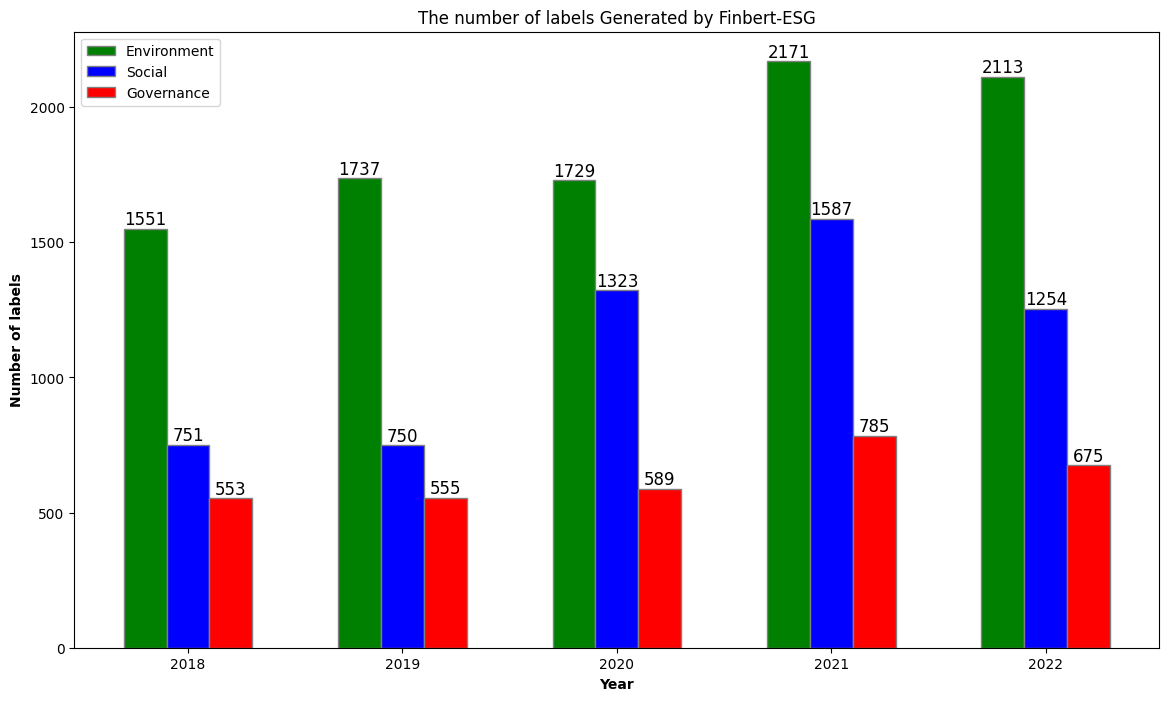

In [138]:
years = np.arange(2018, 2023)

np.random.seed(42)  
category1 = list_E
category2 = list_S
category3 = list_G

bar_width = 0.2
r1 = np.arange(len(years))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(14, 8))
bars1=plt.bar(r1, category1, color='g', width=bar_width, edgecolor='grey', label='Environment')
bars2=plt.bar(r2, category2, color='b', width=bar_width, edgecolor='grey', label='Social')
bars3=plt.bar(r3, category3, color='r', width=bar_width, edgecolor='grey', label='Governance')

for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height()}', ha='center', va='bottom',fontsize=12)
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height()}', ha='center', va='bottom',fontsize=12)
for bar in bars3:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height()}', ha='center', va='bottom',fontsize=12)

plt.title("The number of labels Generated by Finbert-ESG")
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Number of labels', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(years))], years)
plt.legend()

plt.show()

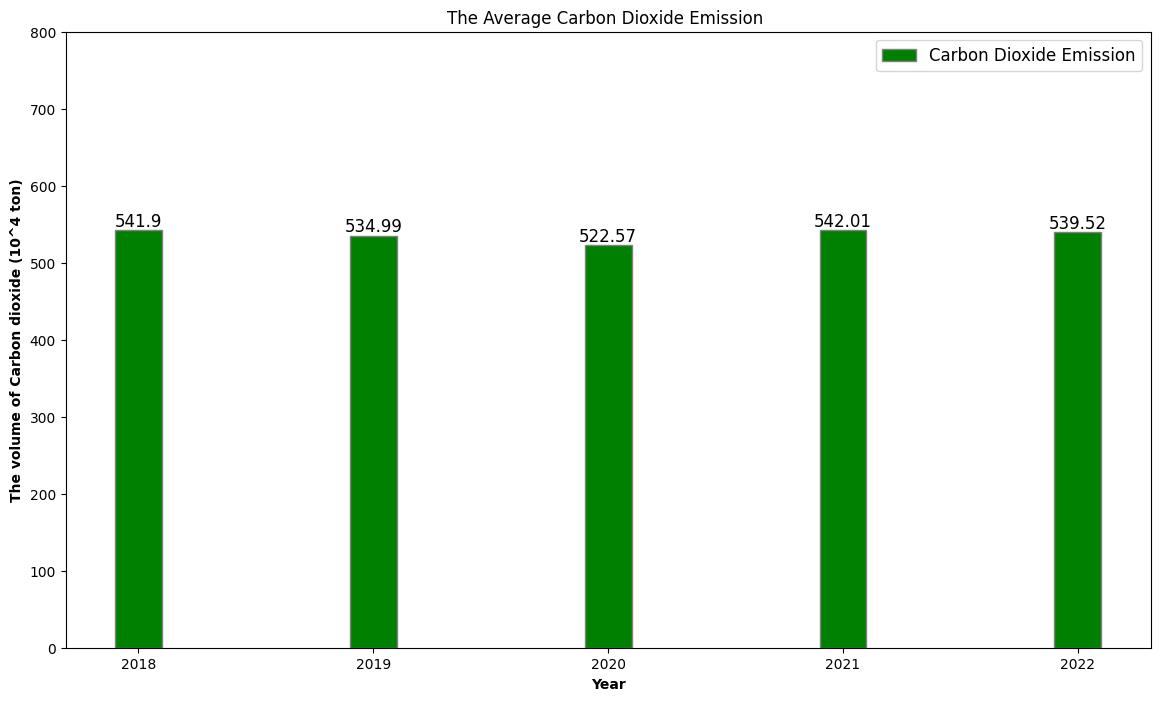

In [13]:
years = np.arange(2018, 2023)

np.random.seed(42)  
category1 = [541.90,534.99,522.57,542.01,539.52]

bar_width = 0.2
r1 = np.arange(len(years))

plt.figure(figsize=(14, 8))
bars1=plt.bar(r1, category1, color='g', width=bar_width, edgecolor='grey', label='Carbon Dioxide Emission')

for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height()}', ha='center', va='bottom',fontsize=12)

plt.title("The Average Carbon Dioxide Emission ")
plt.ylim(0, 800)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('The volume of Carbon dioxide (10^4 ton)', fontweight='bold')
plt.xticks([r for r in range(len(years))], years)
plt.legend(prop={'size': 12}, fontsize='big')
plt.show()

In [9]:
import pandas as pd

df_overall= pd.read_excel('C:/Users/yili8/Desktop/ESG Code/oil&gas(ESG).xlsx', sheet_name='Overall')
filtered_df_overall = df_overall[df_overall['Unnamed: 1'].isin(aimCompanyList)]
filtered_df_overall=filtered_df_overall.sort_values(by='Unnamed: 1').reset_index(drop=True)
filtered_df_overall
filtered_df_overall.to_csv('Aimcompany_overall.csv', index=False)
mean_overall = filtered_df_overall.iloc[:, 2:8].mean().tolist()
mean_overall = [round(num, 2) for num in mean_overall]
print(mean_overall[::-1])


[3.16, 3.56, 3.9, 3.55, 3.57]


In [12]:
df_Env=pd.read_excel('C:/Users/yili8/Desktop/ESG Code/oil&gas(ESG).xlsx', sheet_name='Env')
filtered_df_Env = df_Env[df_Env['Unnamed: 1'].isin(aimCompanyList)]
filtered_df_Env=filtered_df_Env.sort_values(by='Unnamed: 1').reset_index(drop=True)
filtered_df_Env
mean_Env = filtered_df_Env.iloc[:, 2:8].mean().round(2).tolist()
mean_Env = [round(num, 2) for num in mean_Env]
print(mean_Env[::-1])

[2.09, 2.63, 2.97, 2.58, 2.71]


In [13]:
df_Soc=pd.read_excel('C:/Users/yili8/Desktop/ESG Code/oil&gas(ESG).xlsx', sheet_name='Soc')
filtered_df_Soc = df_Soc[df_Soc['Unnamed: 1'].isin(aimCompanyList)]
filtered_df_Soc=filtered_df_Soc.sort_values(by='Unnamed: 1').reset_index(drop=True)
filtered_df_Soc
mean_Soc = filtered_df_Soc.iloc[:, 2:8].mean().round(2).tolist()
mean_Soc = [round(num, 2) for num in mean_Soc]
print(mean_Soc[::-1])

[2.18, 2.5, 3.03, 2.54, 2.42]


In [14]:
df_Gov=pd.read_excel('C:/Users/yili8/Desktop/ESG Code/oil&gas(ESG).xlsx', sheet_name='Gov')
filtered_df_Gov = df_Gov[df_Gov['Unnamed: 1'].isin(aimCompanyList)]
filtered_df_Gov=filtered_df_Gov.sort_values(by='Unnamed: 1').reset_index(drop=True)
filtered_df_Gov
mean_Gov = filtered_df_Gov.iloc[:, 2:8].mean().round(2).tolist()
mean_Gov = [round(num, 2) for num in mean_Gov]
print(mean_Gov[::-1])

[6.53, 6.61, 6.68, 6.73, 6.64]


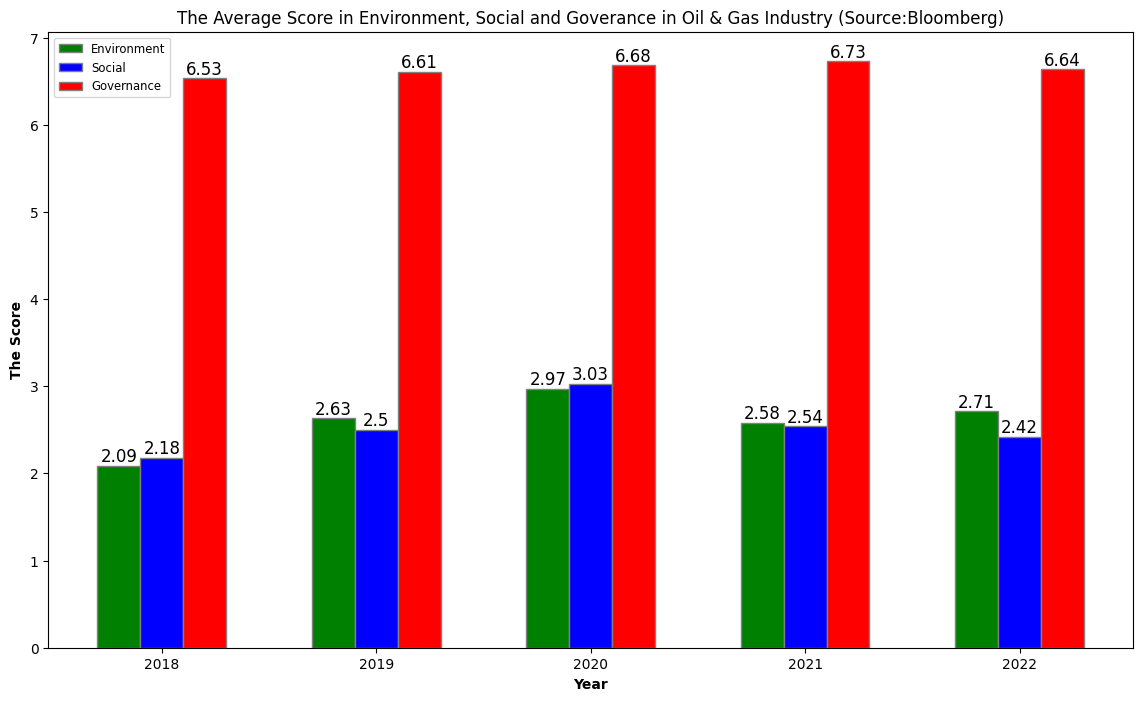

In [43]:
years = np.arange(2018, 2023)

np.random.seed(42) 
category1 = mean_Env[::-1]
category2 = mean_Soc[::-1]
category3 = mean_Gov[::-1]

bar_width = 0.2

r1 = np.arange(len(years))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(14, 8))
bars1=plt.bar(r1, category1, color='g', width=bar_width, edgecolor='grey', label='Environment')
bars2=plt.bar(r2, category2, color='b', width=bar_width, edgecolor='grey', label='Social')
bars3=plt.bar(r3, category3, color='r', width=bar_width, edgecolor='grey', label='Governance')

for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height()}', ha='center', va='bottom', fontsize=12)
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height()}', ha='center', va='bottom', fontsize=12)
for bar in bars3:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height()}', ha='center', va='bottom', fontsize=12)

plt.title("The Average Score in Environment, Social and Goverance in Oil & Gas Industry (Source:Bloomberg)")
plt.xlabel('Year', fontweight='bold')
plt.ylabel('The Score', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(years))], years)
plt.legend(loc="upper left", fontsize='small')
plt.show()

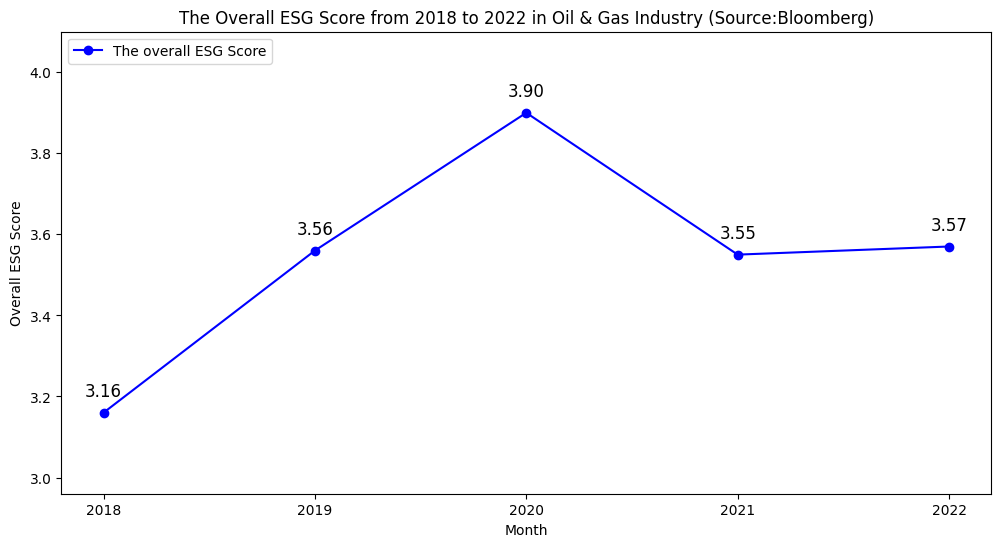

In [10]:
import matplotlib.pyplot as plt

years = np.arange(2018, 2023)
Overall_ESG_Score = mean_overall[::-1]

plt.figure(figsize=(12, 6))
plt.plot(years, Overall_ESG_Score, marker='o', linestyle='-', color='b', label='The overall ESG Score')
plt.title('The Overall ESG Score from 2018 to 2022 in Oil & Gas Industry (Source:Bloomberg)')
plt.xlabel('Month')
plt.ylabel('Overall ESG Score')
for i in range(len(years)):
    plt.text(years[i], Overall_ESG_Score[i] + 0.04, f'{Overall_ESG_Score[i]:.2f}', ha='center', fontsize=12)
plt.xticks(np.arange(min(years), max(years) + 1, 1))
y_min = min(Overall_ESG_Score) - 0.2 
y_max = max(Overall_ESG_Score) + 0.2  
plt.ylim(y_min, y_max)
plt.legend(loc='upper left')
plt.show()

In [46]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        # 压缩输入
        packed_input = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hn, cn) = self.lstm(packed_input)
        output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        output = self.fc(output[:, -1, :])
        return output

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class RNN_Model(nn.Module):
    def __init__(self,n_input,n_hidden,n_class=1):
        super(RNN_Model, self).__init__()
        self.rnn = nn.RNN(n_input, n_hidden, num_layers=2, batch_first=True)
        # Linear layer for output
        self.linear = nn.Linear(n_hidden,n_class)

    def forward(self, x):
        rnn_output, h_n = self.rnn(x)
        x_last = rnn_output[:,-1,:] 
        x = self.linear(x_last)
        return x

In [3]:
df = pd.read_csv('C:/Users/yili8/Desktop/ESG Code/Aimcompany_overall(With mean value).csv')  
columns = df[['2018', '2019', '2020','2021','2022']]  
column1_list = df['2018'].tolist()  
column2_list = df['2019'].tolist()  
column3_list = df['2020'].tolist()  
column4_list = df['2021'].tolist()  
column5_list= df['2022'].tolist()
result_list = column1_list+column2_list+column3_list+column4_list
print(len(result_list))

224


In [27]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
import glob
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_Model, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        out = self.fc(out)
        return out

input_size = 3
hidden_size = 5
num_layers = 1
output_size = 1
num_epochs = 30
learning_rate = 0.001
i=0

model = LSTM_Model(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

input_data = []
output_data = []
input_data_test=[]

for y in range(2018, 2022):
    file_pattern = f'C:/Users/yili8/Desktop/ESG Code/{y}/*.csv'
    for file in glob.glob(file_pattern):
        df = pd.read_csv(file)
        sixth_column = df.iloc[:, 5]
        counts = sixth_column.value_counts().reindex(['E', 'S', 'G'], fill_value=0)
        input_data.append(torch.tensor(counts.values/len(sixth_column), dtype=torch.float32))
        output_data.append(result_list[i])
        i += 1
X_tensor = torch.tensor(np.array(input_data), dtype=torch.float32)
y_tensor = torch.tensor(np.array(output_data), dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
for epoch in range(num_epochs):
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.unsqueeze(1)  # Add the sequence dimension

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [10/30], Loss: 2.3548
Epoch [20/30], Loss: 2.3653
Epoch [30/30], Loss: 0.3282


In [28]:
import torch.nn.functional as F
predict_result=[]
for file in glob.glob('C:/Users/yili8/Desktop/ESG Code/2022/*.csv'):
    df = pd.read_csv(file)
    sixth_column = df.iloc[:, 5]
    # Count the occurrences of 'E', 'S', 'G'
    counts_test = sixth_column.value_counts().reindex(['E', 'S', 'G'], fill_value=0)
    print(counts_test)
    test_input = torch.tensor([counts_test.values/len(sixth_column)], dtype=torch.float32).unsqueeze(1)
    print(test_input)
    model.eval()
    with torch.no_grad():
        predicted_value = model(test_input)
        predict_result.append(predicted_value.item())
        print(f'Predicted value for {file}: {predicted_value.item()}')
predict_result_tensor = torch.tensor(predict_result, dtype=torch.float32)
column5_tensor = torch.tensor(column5_list, dtype=torch.float32)
print(predict_result)
print(column5_list)
mse = F.mse_loss(predict_result_tensor, column5_tensor)
rmse = np.sqrt(mse)
mae = F.l1_loss(predict_result_tensor, column5_tensor)
ss_tot = torch.sum((column5_tensor - torch.mean(column5_tensor)) ** 2)
ss_res = torch.sum((column5_tensor - predict_result_tensor) ** 2)
r2 = 1 - (ss_res / ss_tot)
# P-value calculation
correlation_coefficient, p_value = stats.pearsonr(predict_result, column5_list)
results = pd.DataFrame([['LSTM', mse.item(), rmse.item(), mae.item(), r2.item(), p_value]],
                       columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2Score', 'P-value'])
print(results)


final_label
E    6
S    7
G    2
Name: count, dtype: int64
tensor([[[0.0170, 0.0199, 0.0057]]])
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\AE-2022.csv output.csv: 3.254026412963867
final_label
E    202
S     59
G     13
Name: count, dtype: int64
tensor([[[0.1501, 0.0438, 0.0097]]])
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\AR-2022.csv output.csv: 3.390892744064331
final_label
E    127
S     56
G     11
Name: count, dtype: int64
tensor([[[0.1269, 0.0559, 0.0110]]])
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\AROC-2022.csv output.csv: 3.3782730102539062
final_label
E    30
S    38
G    25
Name: count, dtype: int64
tensor([[[0.0175, 0.0222, 0.0146]]])
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\BOOM-2022.csv output.csv: 3.2601888179779053
final_label
E    12
S     0
G    10
Name: count, dtype: int64
tensor([[[0.0164, 0.0000, 0.0137]]])
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\BSM-2022.csv output.csv: 3.2448413372039795

In [35]:
df_lstm = pd.DataFrame({'Column1': predict_result, 'Column2': column5_list})
df_lstm.to_csv('Greenwashing_lstm.csv', index=False)
print("Arrays have been saved to 'output.csv'")

Arrays have been saved to 'output.csv'


In [50]:
import torch
import torch.nn as nn
import glob
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

class RNN_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN_Model, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.rnn(x)
        out = lstm_out[:, -1, :]
        out = self.fc(out)
        return out

# Hyperparameters
input_size = 3
hidden_size = 5
num_layers = 1  
output_size = 1
num_epochs = 100
learning_rate = 0.001
i=0

model_rnn = RNN_Model(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)

input_data = []
output_data = []

for y in range(2018, 2022):
    file_pattern = f'C:/Users/yili8/Desktop/ESG Code/{y}/*.csv'
    for file in glob.glob(file_pattern):
        df = pd.read_csv(file)
        sixth_column = df.iloc[:, 5]
        counts = sixth_column.value_counts().reindex(['E', 'S', 'G'], fill_value=0)
        input_data.append(torch.tensor(counts.values/len(sixth_column), dtype=torch.float32))
        scaler_X = MinMaxScaler()
        input_data_scaled = scaler_X.fit_transform(input_data)
        output_data.append(result_list[i])
        i += 1

X_tensor = torch.tensor(np.array(input_data_scaled), dtype=torch.float32)
y_tensor = torch.tensor(np.array(output_data), dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for epoch in range(num_epochs):
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.unsqueeze(1)  # Add the sequence dimension
        optimizer.zero_grad()
        outputs = model_rnn (X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0255
Epoch [20/100], Loss: 2.3459
Epoch [30/100], Loss: 4.1516
Epoch [40/100], Loss: 0.3281
Epoch [50/100], Loss: 2.5135
Epoch [60/100], Loss: 1.8125
Epoch [70/100], Loss: 3.0158
Epoch [80/100], Loss: 0.0271
Epoch [90/100], Loss: 2.9876
Epoch [100/100], Loss: 0.0609


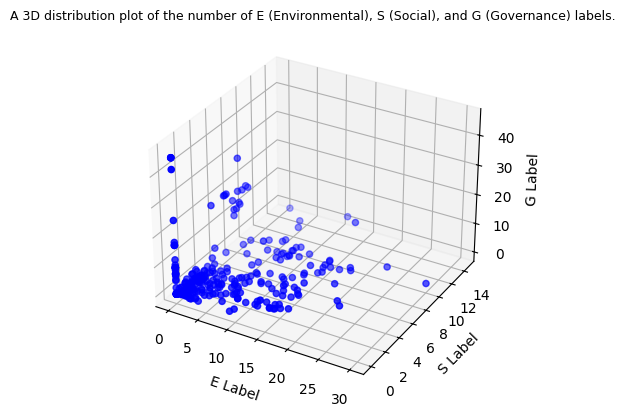

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import glob
x_array=[]
y_array=[]
z_array=[]
for y in range(2018, 2023):
    file_pattern = f'C:/Users/yili8/Desktop/ESG Code/{y}/*.csv'
    for file in glob.glob(file_pattern):
        df = pd.read_csv(file)
        sixth_column = df.iloc[:, 5]
        counts_E = sixth_column.value_counts().reindex(['E'], fill_value=0)
        counts_S = sixth_column.value_counts().reindex(['S'], fill_value=0)
        counts_G = sixth_column.value_counts().reindex(['G'], fill_value=0)
        counts_E_value=(counts_E.values/len(sixth_column))*100
        counts_S_value=(counts_S.values/len(sixth_column))*100
        counts_G_value=(counts_G.values/len(sixth_column))*100
        x_array.append(counts_E_value)
        y_array.append(counts_S_value)
        z_array.append(counts_G_value)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_array, y_array, z_array, c='b', marker='o')
ax.set_xlabel('E Label')
ax.set_ylabel('S Label')
ax.set_zlabel('G Label')
plt.title('A 3D distribution plot of the number of E (Environmental), S (Social), and G (Governance) labels.',fontsize=9)
plt.show()

In [51]:
predict_result_rnn = []

# Loop through each file and process
for file in glob.glob('C:/Users/yili8/Desktop/ESG Code/2022/*.csv'):
    df = pd.read_csv(file)
    sixth_column = df.iloc[:, 5]
    counts_test = sixth_column.value_counts().reindex(['E', 'S', 'G'], fill_value=0)
    scaler_X.fit(input_data)
    counts_test_scaled = scaler_X.transform([counts_test.values/len(sixth_column)])  # Scale the input features
    test_input = torch.tensor(counts_test_scaled, dtype=torch.float32).unsqueeze(1)  # Shape: [3, 1]
    print(test_input)
    model_rnn.eval()
    with torch.no_grad():
        predicted_value_rnn = model_rnn(test_input)
        predict_result_rnn.append(predicted_value_rnn.item())
        print(f'Predicted value for {file}: {predicted_value_rnn.item()}')

# Convert results to tensors
predict_result_tensor_rnn = torch.tensor(predict_result_rnn, dtype=torch.float32)
column5_tensor = torch.tensor(column5_list, dtype=torch.float32)
print(predict_result_rnn)
print(column5_list)

# Calculate MSE, RMSE, MAE, and R² for RNN
mse_rnn = F.mse_loss(predict_result_tensor_rnn, column5_tensor)
rmse_rnn = torch.sqrt(mse_rnn)
mae_rnn = F.l1_loss(predict_result_tensor_rnn, column5_tensor)
ss_tot_rnn = torch.sum((column5_tensor - torch.mean(column5_tensor)) ** 2)
ss_res_rnn = torch.sum((column5_tensor - predict_result_tensor_rnn) ** 2)
r2_rnn = 1 - (ss_res_rnn / ss_tot_rnn)

# P-value calculation
correlation_coefficient_rnn, p_value_rnn = stats.pearsonr(predict_result, column5_list)
results_rnn = pd.DataFrame([['RNN', mse_rnn.item(), rmse_rnn.item(), mae_rnn.item(), r2_rnn.item(), p_value_rnn]],
                       columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2Score', 'P-value'])
print(results_rnn)


tensor([[[0.0568, 0.1369, 0.0125]]])
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\AE-2022.csv output.csv: 3.183976650238037
tensor([[[0.5002, 0.3018, 0.0212]]])
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\AR-2022.csv output.csv: 3.7279112339019775
tensor([[[0.4229, 0.3852, 0.0242]]])
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\AROC-2022.csv output.csv: 3.6188888549804688
tensor([[[0.0585, 0.1530, 0.0322]]])
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\BOOM-2022.csv output.csv: 3.191340923309326
tensor([[[0.0546, 0.0000, 0.0301]]])
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\BSM-2022.csv output.csv: 3.2723443508148193
tensor([[[0.1520, 0.0897, 0.0000]]])
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\CHK-2022.csv output.csv: 3.366889476776123
tensor([[[0.3038, 0.4706, 0.0501]]])
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\CNX-2022.csv output.csv: 3.440603494644165
tensor([[[0.3509, 0.0000, 0.1158]]])
P

In [36]:
df_RNN = pd.DataFrame({'Column1': predict_result_rnn, 'Column2': column5_list})
df_RNN.to_csv('Greenwashing_rnn.csv', index=False)
print("Arrays have been saved to 'output.csv'")

Arrays have been saved to 'output.csv'


In [47]:
import torch
import torch.nn as nn
import glob
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

# Define CNN Model
class CNN_Model(nn.Module):
    def __init__(self, input_size, num_filters, kernel_size, output_size):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        # Assuming global average pooling will reduce the dimension to num_filters*2
        self.fc = nn.Linear(num_filters*2, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.mean(dim=2)  # Global average pooling
        out = self.fc(x)
        out = torch.relu(out)  # Ensures the output is non-negative
        return out

input_size = 3
num_filters = 5
kernel_size = 1
output_size = 1
num_epochs = 20
learning_rate = 0.001
i = 0

cnnmodel = CNN_Model(input_size=input_size, num_filters=num_filters, kernel_size=kernel_size, output_size=output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnnmodel.parameters(), lr=learning_rate)

input_data = []
output_data = []

for y in range(2018, 2022):
    file_pattern = f'C:/Users/yili8/Desktop/ESG Code/{y}/*.csv'
    for file in glob.glob(file_pattern):
        df = pd.read_csv(file)
        sixth_column = df.iloc[:, 5]
        counts = sixth_column.value_counts().reindex(['E', 'S', 'G'], fill_value=0)
        input_data.append(torch.tensor(counts.values, dtype=torch.float32))
        output_data.append(result_list[i])
        i += 1

X_tensor = torch.tensor(np.array(input_data), dtype=torch.float32).unsqueeze(2)
y_tensor = torch.tensor(np.array(output_data), dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for epoch in range(num_epochs):
    for X_batch, y_batch in dataloader:
        optimizer.zero_grad()
        outputs = cnnmodel(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/20], Loss: 4.8590
Epoch [20/20], Loss: 0.5854


In [48]:
import torch.nn.functional as F
predict_result_cnn=[]
for file in glob.glob('C:/Users/yili8/Desktop/ESG Code/2022/*.csv'):
    df = pd.read_csv(file)
    sixth_column = df.iloc[:, 5]
    # Count the occurrences of 'E', 'S', 'G'
    counts_test = sixth_column.value_counts().reindex(['E', 'S', 'G'], fill_value=0)
    test_input = torch.tensor([counts_test.values], dtype=torch.float32).unsqueeze(2)
    cnnmodel.eval()
    with torch.no_grad():
        predicted_value = cnnmodel(test_input)
        predict_result_cnn.append(predicted_value.item())
        print(f'Predicted value for {file}: {predicted_value.item()}')
predict_result_tensor = torch.tensor(predict_result_cnn, dtype=torch.float32)
column5_tensor = torch.tensor(column5_list, dtype=torch.float32)
# Calculate MSE, RMSE, MAE, and R² for RNN
mse_cnn = F.mse_loss(predict_result_tensor, column5_tensor)
rmse_cnn = torch.sqrt(mse_cnn)
mae_cnn = F.l1_loss(predict_result_tensor, column5_tensor)
ss_tot_cnn = torch.sum((column5_tensor - torch.mean(column5_tensor)) ** 2)
ss_res_cnn = torch.sum((column5_tensor - predict_result_tensor) ** 2)
r2_cnn = 1 - (ss_res_cnn / ss_tot_cnn)

# P-value calculation
correlation_coefficient_cnn, p_value_cnn = stats.pearsonr(predict_result_cnn, column5_list)
results_cnn = pd.DataFrame([['CNN', mse_cnn.item(), rmse_cnn.item(), mae_cnn.item(), r2_cnn.item(), p_value_cnn]],
                       columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2Score', 'P-value'])
print(results_cnn)

Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\AE-2022.csv output.csv: 3.3163390159606934
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\AR-2022.csv output.csv: 2.83345890045166
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\AROC-2022.csv output.csv: 2.9625792503356934
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\BOOM-2022.csv output.csv: 3.326864719390869
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\BSM-2022.csv output.csv: 3.654510974884033
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\CHK-2022.csv output.csv: 3.3712191581726074
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\CNX-2022.csv output.csv: 3.1349799633026123
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\CQP-2022.csv output.csv: 3.362293243408203
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\CTRA-2022.csv output.csv: 3.3141088485717773
Predicted value for C:/Users/yili8/Desktop/ESG Code/2022\CVX-2022.csv output.csv: 3.37105655670

In [49]:
df_CNN = pd.DataFrame({'Column1': predict_result_cnn, 'Column2': column5_list})
df_CNN.to_csv('Greenwashing_cnn.csv', index=False)
print("Arrays have been saved to 'Greenwashing_cnn.csv'")

Arrays have been saved to 'output.csv'
